# Instructions

Please refer to [README file details]

Here's the docker cmd to run from /notebooks:

docker run  -dit --rm --name notebook -p 8888:8888 -e JUPYTER_ENABLE_LAB=yes -v "$PWD"/..:/home/jovyan/work ajduncanson/nba-modelling


### Introduction

This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, LogisticRegression model is used.

### Import the libraries

In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import os
import sys
sys.path.append(os.path.abspath('..'))

from src.common_lib import DataReader, NBARawData
from src.common_lib import confusion_matrix, plot_roc, eval_report
#from src.models import aj_metrics

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import dump

from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [8]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Examine features by class

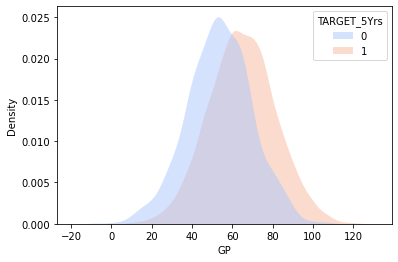

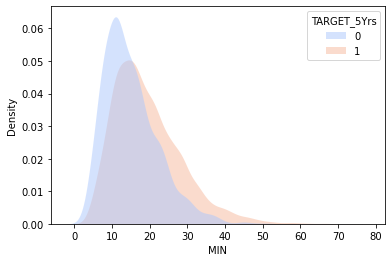

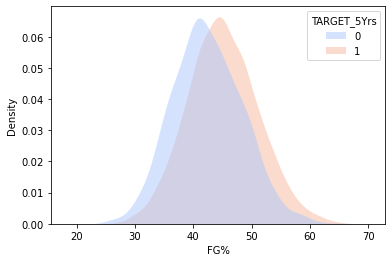

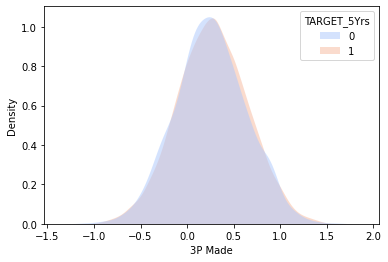

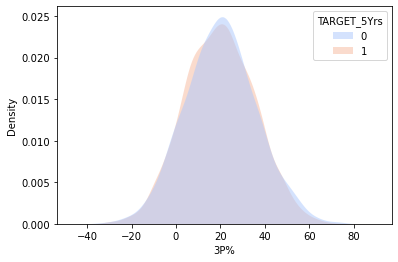

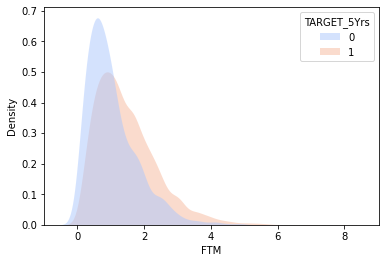

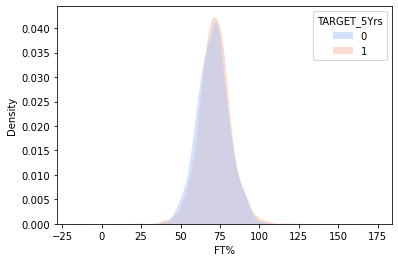

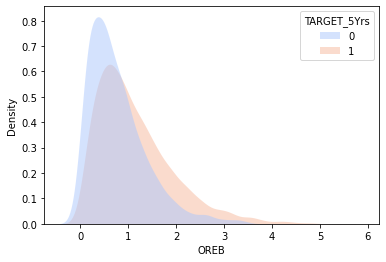

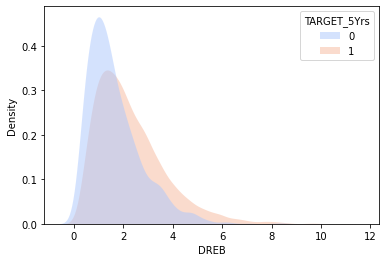

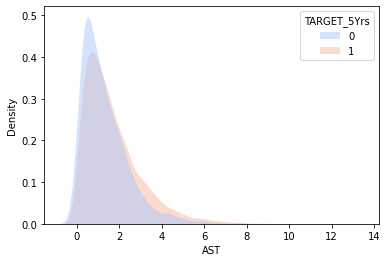

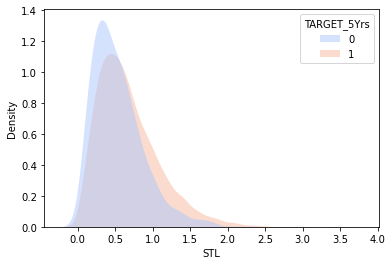

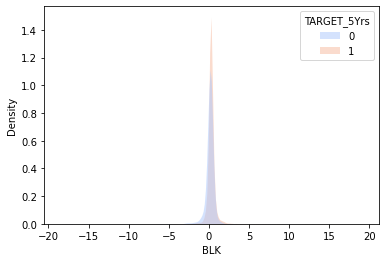

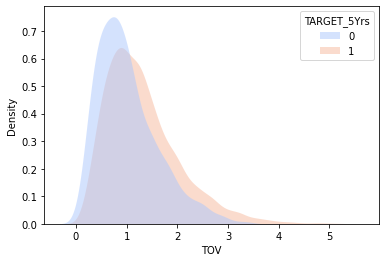

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.pairplot(train_df_scaled, hue="TARGET_5Yrs")


chart_cols = selected_features[0:-1]

for c in chart_cols:
    length_fig, length_ax = plt.subplots()
    sns.kdeplot(data=train_df, x=c, hue="TARGET_5Yrs", fill=True, common_norm=False, palette="coolwarm", alpha=.5, linewidth=0)

### Class Balance Check on Raw Data

Propotion:  0.2 :1
Counter({6669: 1, 1331: 1})


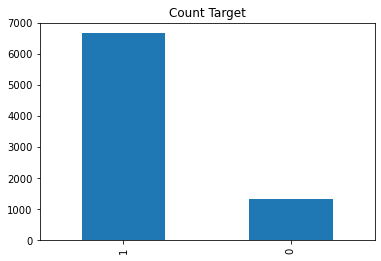

In [9]:
target_count = train_df["TARGET_5Yrs"].value_counts()
print('Propotion: ', round(target_count[0]/ target_count[1], 2), ":1")

print( Counter(target_count))
data_reader.plot_class_balance(train_df["TARGET_5Yrs"])

### Scaling with Standard Scaler

In [37]:
## Scaling
df_cleaned = train_df.copy()
target = df_cleaned.pop('TARGET_5Yrs')

train_df_scaled = data_reader.scale_features_by_standard_scaler(df_cleaned)
train_df_scaled

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.930059,-1.731834,1.006100,0.640574,0.123403,0.113959,0.047090,0.177269,-0.428374,-0.486911,...,0.655953,0.760387,0.070392,1.428377,-0.121037,0.266040,1.161949,1.107242,-0.055071,0.473210
1,-0.380914,-1.731401,0.714005,0.360766,0.748626,0.822648,0.465578,1.704465,-1.469853,-1.712288,...,1.087875,1.319370,-0.341888,3.210407,1.100107,1.608950,-0.681844,-0.364787,0.432148,0.196671
2,-0.286878,-1.730968,1.298195,0.058574,-0.640758,-0.535673,-0.482994,-0.293888,0.352736,0.361427,...,-1.071732,-1.076272,0.415557,-0.608229,-0.264701,-0.405415,-0.608092,-0.610125,-0.055071,-0.909485
3,1.743194,-1.730535,0.012976,0.058574,0.216029,0.409246,0.130788,1.282049,0.092366,-0.015612,...,-0.531830,-0.357579,-0.428180,-0.353653,-0.121037,-0.117649,0.129425,-0.610125,-0.176876,0.888019
4,-0.348731,-1.730102,0.012976,-0.086926,-0.826009,-0.653788,-0.789885,1.005854,0.613106,0.549947,...,-1.287692,-1.156127,-1.665021,1.682952,0.381787,0.793612,-0.903099,-0.610125,0.432148,-0.771215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.970776,1.730102,-1.798014,-1.049465,-1.265980,-1.244362,-1.236272,-0.700057,-0.949113,-0.958210,...,-1.071732,-1.076272,-0.543235,-0.990093,-0.264701,-0.645220,-0.829347,-0.855464,-0.055071,-1.186024
7996,1.212418,1.730535,-0.512795,-1.407619,-1.265980,-1.244362,-1.347869,0.664672,-0.428374,-0.675430,...,-1.287692,-1.235982,-0.121366,-0.099078,-0.767525,-0.597259,-1.124354,-1.591478,0.066734,-1.324294
7997,-0.331885,1.730968,1.298195,1.077074,0.794939,0.704533,0.772469,0.079788,-0.168004,-0.204131,...,1.519796,1.558934,-0.159718,-0.099078,-0.049205,-0.069687,1.309452,1.352580,-0.055071,0.749749
7998,-1.399219,1.731401,-1.389081,-1.217350,-1.103885,-1.067190,-1.096776,-0.732551,-1.469853,-1.240989,...,-0.855771,-0.996417,0.281326,-0.862805,-1.126685,-1.124831,-1.050602,-0.855464,0.066734,-1.047755


### Select Features

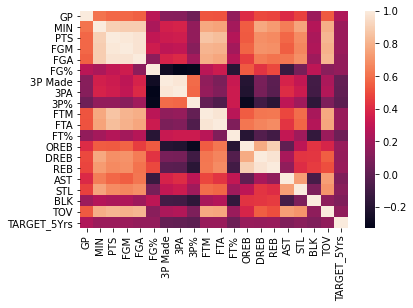

In [38]:
train_df_scaled['TARGET_5Yrs'] = target
selected_features = data_reader.select_feature_by_correlation(train_df_scaled, ['Id', 'Id_old'])

In [39]:
selected_features

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')

In [40]:
train_df_scaled  = train_df_scaled[selected_features]
train_df_scaled.head()

,GP,MIN,FG%,3P Made,3P%,FTM,FT%,OREB,DREB,AST,STL,BLK,TOV,TARGET_5Yrs
0,1.006100,0.640574,0.177269,-0.428374,0.188493,0.655953,0.070392,1.428377,-0.121037,1.161949,1.107242,-0.055071,0.473210,1
1,0.714005,0.360766,1.704465,-1.469853,0.957140,1.087875,-0.341888,3.210407,1.100107,-0.681844,-0.364787,0.432148,0.196671,1
2,1.298195,0.058574,-0.293888,0.352736,0.919645,-1.071732,0.415557,-0.608229,-0.264701,-0.608092,-0.610125,-0.055071,-0.909485,1
3,0.012976,0.058574,1.282049,0.092366,0.257234,-0.531830,-0.428180,-0.353653,-0.121037,0.129425,-0.610125,-0.176876,0.888019,1
4,0.012976,-0.086926,1.005854,0.613106,-0.367682,-1.287692,-1.665021,1.682952,0.381787,-0.903099,-0.610125,0.432148,-0.771215,1


### Split Train and Test on Scaled Data with Selected Features

In [42]:
X_train, X_val, y_train, y_val = data_reader.split_data(train_df_scaled)

Counter({1: 5326, 0: 1074})


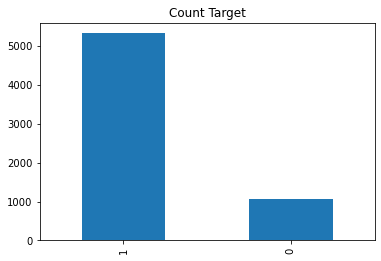

In [43]:
### Visualisation Before Sampling Classification Count
print( Counter(y_train))
data_reader.plot_class_balance(y_train)

Counter({1: 1343, 0: 257})


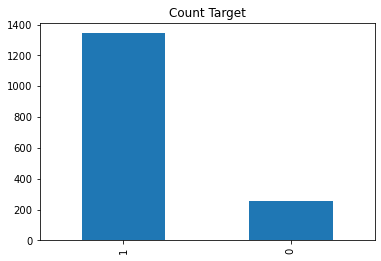

In [44]:
print(Counter(y_val))
data_reader.plot_class_balance(y_val)

### Re-sampling -  Over Sampling

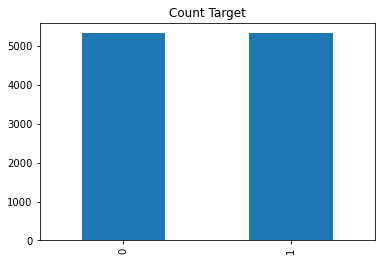

In [45]:
# Resample Train Data
X_train_res, y_train_res = data_reader.resample_data_upsample_smote(X_train, y_train)

# Re-plot the target
data_reader.plot_class_balance(y_train_res)

### Build The Model - Logistic Regression

In [46]:
log_reg = LogisticRegression().fit(X_train_res, y_train_res)

### Accuracy Test on Train Set

In [47]:
y_train_prob = log_reg.predict_proba(X_train)[:,1]

## Check Accuracy Score
y_pred_train=log_reg.predict(X_train)


Confusion Matrix:
        pred:0  pred:1
true:0     712     362
true:1    1891    3435

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.66      0.39      1074
           1       0.90      0.64      0.75      5326

    accuracy                           0.65      6400
   macro avg       0.59      0.65      0.57      6400
weighted avg       0.80      0.65      0.69      6400


ROC Curve:
AUC = 0.654


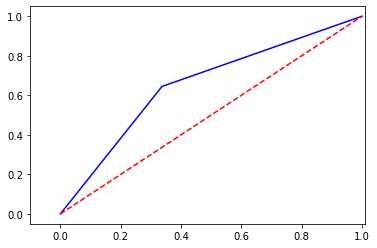

In [48]:
## Confusion matrix, metrics and AUC plot
eval_report(y_train, y_pred_train)

### Accuracy Check on Validation Set

In [49]:
y_prob_val=log_reg.predict_proba(X_val)[:,1]

## Check Accuracy Score
y_pred_val=log_reg.predict(X_val)


Confusion Matrix:
        pred:0  pred:1
true:0     170      87
true:1     491     852

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.66      0.37       257
           1       0.91      0.63      0.75      1343

    accuracy                           0.64      1600
   macro avg       0.58      0.65      0.56      1600
weighted avg       0.80      0.64      0.69      1600


ROC Curve:
AUC = 0.648


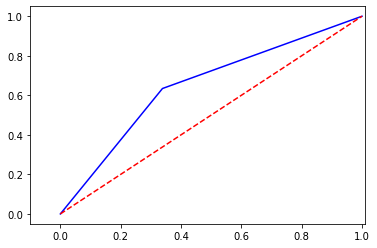

In [50]:
## Confusion matrix, metrics and AUC plot
eval_report(y_val, y_pred_val)

### Prediction on Test Set 

In [51]:
# Remove the target column, because the raw test set does not contain it
features_without_target = np.delete(selected_features, 13)
test_df = test_df[features_without_target]

# apply scaling
test_df_scaled =  data_reader.scale_features_by_standard_scaler(test_df)


In [52]:
# predictions

y_test_proba =log_reg.predict_proba(test_df_scaled)[:,1]

final_prediction_test = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_proba]})

final_prediction_test.head(10)

,Id,TARGET_5Yrs
0,0,0.477408
1,1,0.454545
2,2,0.732773
3,3,0.783287
4,4,0.412399
5,5,0.714216
6,6,0.333125
7,7,0.419366
8,8,0.559182
9,9,0.201586


In [53]:
#save predictions to file
#final_prediction_test.to_csv("../reports/tin_submission_stdscale_smote_logistic_regression_selFeatures.csv", index=False)


### Coefficients

In [63]:

coef_table = pd.DataFrame({'Feature': features_without_target, 'Coefficient': log_reg.coef_[0]})

coef_table

,Feature,Coefficient
0,GP,0.559949
1,MIN,-0.057955
2,FG%,0.247956
3,3P Made,0.031712
4,3P%,0.068353
5,FTM,0.063773
6,FT%,0.045939
7,OREB,0.393650
8,DREB,-0.070485
9,AST,0.234847


## Variable importance by permutation


In [64]:
from sklearn.inspection import permutation_importance

In [65]:
r = permutation_importance(
    log_reg, X_train, y_train,
    n_repeats=30,
    random_state=8
)

In [66]:
table = pd.DataFrame(r.importances_mean)
table.index = X_train.columns

In [67]:
importances = pd.DataFrame({'Feature': features_without_target, 'importance': r.importances_mean})

importances

,Feature,importance
0,GP,0.026724
1,MIN,0.005766
2,FG%,0.004786
3,3P Made,0.001068
4,3P%,0.006250
5,FTM,-0.002281
6,FT%,0.002271
7,OREB,0.006620
8,DREB,0.007995
9,AST,0.009974
